In [171]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [172]:
ntuples = '20170526'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,diphotonJets,-1)
utils.IO.add_background(ntuples,gJets_lowPt,-2)
utils.IO.add_background(ntuples,gJets_highPt,-2)

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/AllNonResSig_20170526.root


In [173]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,noexpand:sqrt((diphotonCandidate.Eta()-dijetCandidate.Eta())*(diphotonCandidate.Eta()-dijetCandidate.Eta())+TVector2::Phi_mpi_pi(subleadingPhoton.Phi()-dijetCandidate.Phi())*TVector2::Phi_mpi_pi(diphotonCandidate.Phi()-dijetCandidate.Phi()))'.split(",")
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


utils.preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=utils.preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
weights_bkg,weights_sig=utils.preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = utils.preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = utils.preprocessing.randomize(X_sig,y_sig,weights_sig)


y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = utils.preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = utils.preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = utils.preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'noexpand:sqrt((diphotonCandidate.Eta()-dijetCandidate.Eta())*(diphotonCandidate.Eta()-dijetCandidate.Eta())+TVector2::Phi_mpi_pi(subleadingPhoton.Phi()-dijetCandidate.Phi())*TVector2::Phi_mpi_pi(diphotonCandidate.Phi()-dijetCandidate.Phi()))']


In [ ]:
import xgboost as xgb
#FIXME parameteres
clf = xgb.XGBClassifier(max_depth=10,learning_rate=0.2,n_estimators=500, min_child_weight=1e-5, nthread= 12)
#clf = xgb.XGBClassifier(max_depth=5,learning_rate=0.2,n_estimators=100, min_child_weight=1e-5, nthread= 12)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)

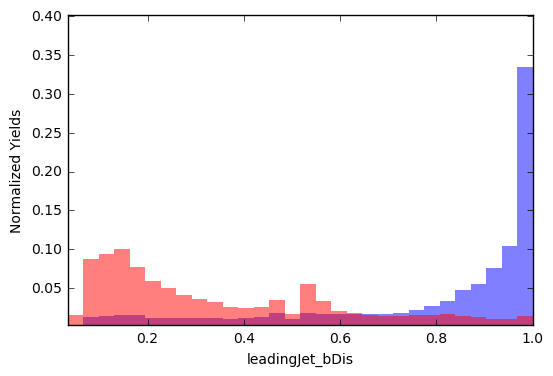

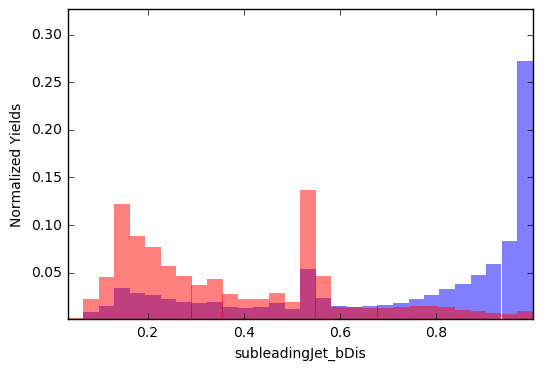

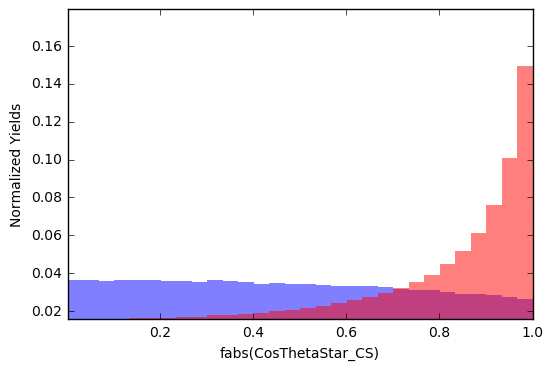

KeyboardInterrupt: 

In [229]:
#FIXME, do weighted plots?
utils.plotting.plot_input_variables(X_sig,X_bkg,branch_names)

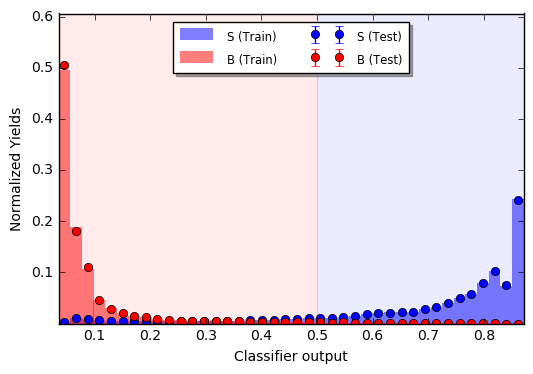

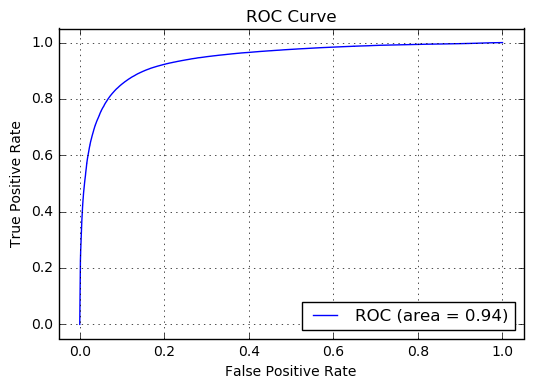

In [170]:
import matplotlib.pyplot as plt

X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)
y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg")
plt.show()
utils.plotting.plot_roc_curve_multiclass(X_total_test,y_total_test,clf,outString="xgbr")
plt.show()

[ 0.44991124  0.09980141  0.10866517 ...,  0.11336236  0.10597639
  0.11570879]


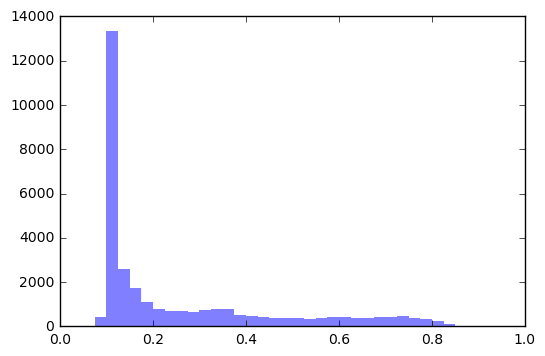

In [130]:
bkg_train = X_total_train[y_total_train == -2]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

[ 0.83922446  0.60158145  0.57028127 ...,  0.48143157  0.77341425
  0.35218373]


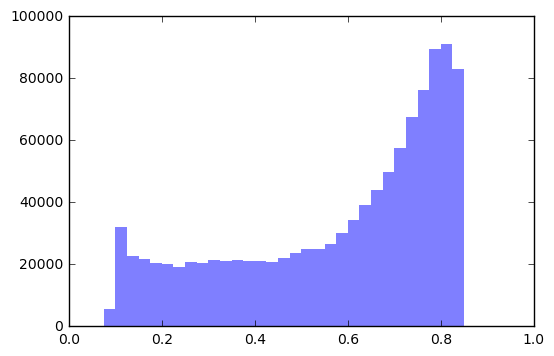

In [131]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

[ 0.85418707  0.85591769  0.6597082  ...,  0.7086038   0.8674444
  0.74755448]


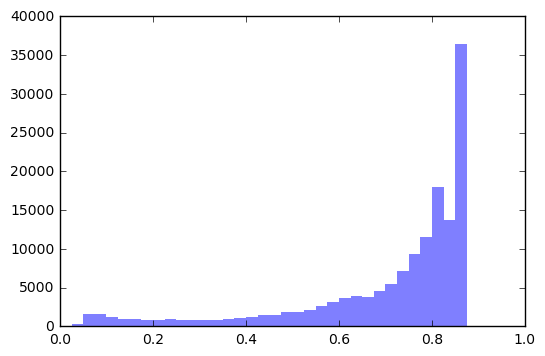

In [132]:
sig_train = X_total_train[y_total_train == 1]
print clf.predict_proba(sig_train)[:,2] 
Y_pred_sig_train = clf.predict_proba(sig_train)[:,2]

Histo_training_S = np.histogram(Y_pred_sig_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()